In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook"])
# plt.style.use("default")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Params(transition_matrix=array([[0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.01],
       [0.  , 0.  , 1.  ]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.25, population_graph=<networkx.classes.graph.Graph object at 0x7f58b0d2a760>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


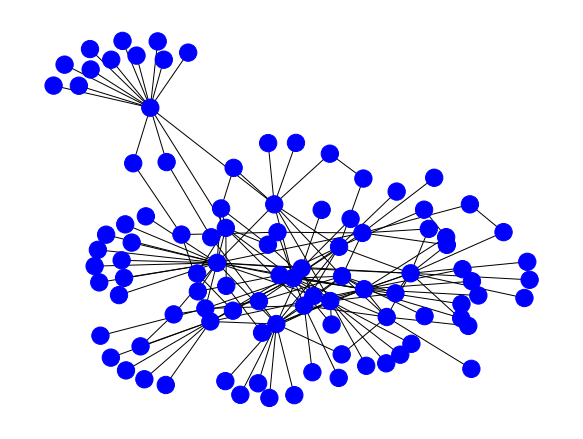

In [84]:
SEED = 13

np.random.seed(SEED)

TAU   = 0.25
RHO   = 0.01
ide.GRAPHS["scale"] = nx.generators.random_internet_as_graph(100, seed=SEED)
# ide.GRAPHS["scale"] = nx.Graph(nx.generators.scale_free_graph(100, seed=SEED).to_undirected())
G = ide.GRAPHS["scale"]
# G.remove_edges_from(nx.selfloop_edges(G))
for _ in range(20):
    u = np.random.choice(range(50))
    v = np.random.choice(range(50, 99))
    G.add_edge(u, v)

EXP = ide.Experiment()
EXP.graph_name = "scale"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
EXP.agent_constructor = ide.NullAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=SEED)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

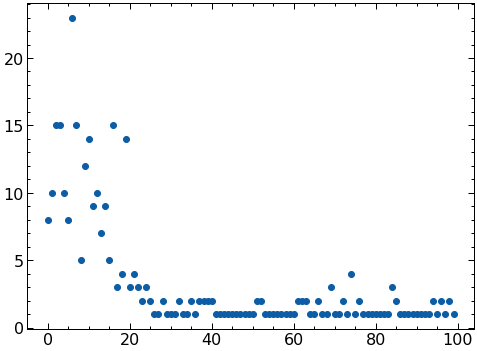

In [85]:
G = ide.GRAPHS["scale"]
x = G.nodes()
y = [G.degree(n) for n in x]

plt.scatter(x, y)
plt.show()

In [11]:
from tqdm import trange

def _num_sickdays(states):
    n = np.zeros(states.shape[1], dtype=int)
    for i in range(states.shape[1]):
        col = states[:, i]
        n[i] = np.count_nonzero(col == 1)
    return n

def process_metrics(i, metrics, results):
    states = np.array(results["states"])
    num_sickdays = _num_sickdays(states)
    total_sickdays = np.sum(num_sickdays)
    metrics["num_sickdays"] += num_sickdays
    metrics["total_sickdays"] += total_sickdays

def run_simulations(n_sims, exp):
    size = ide.GRAPHS[exp.graph_name].number_of_nodes()
    metrics = {
        "num_sickdays": np.zeros(size),
        "total_sickdays": 0
    }

    exp.scenario_builder()
    for i in trange(n_sims):
        exp.seed = i
        # np.random.seed(i)
        r = exp.run()
        process_metrics(i, metrics, r["metric_results"])
    return metrics

In [86]:
EXP.num_steps = 20
N = 100

EXP.agent_constructor = ide.NullAgent
null_metrics = run_simulations(N, EXP)

EXP.agent_constructor = ide.RandomAgent
rng_metrics = run_simulations(N, EXP)

EXP.agent_constructor = ida.RandomNeighborAgent
rnn_metrics = run_simulations(N, EXP)

EXP.agent_constructor = ida.PrecisionRandomAgent
prr_metrics = run_simulations(N, EXP)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [87]:
EXP.agent_constructor = ida.CentralityAgent
ida.CENTRALITY_FUNCION = nx.centrality.degree_centrality
deg_metrics = run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.eigenvector_centrality
eig_metrics = run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.betweenness_centrality
btw_metrics = run_simulations(N, EXP)

100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


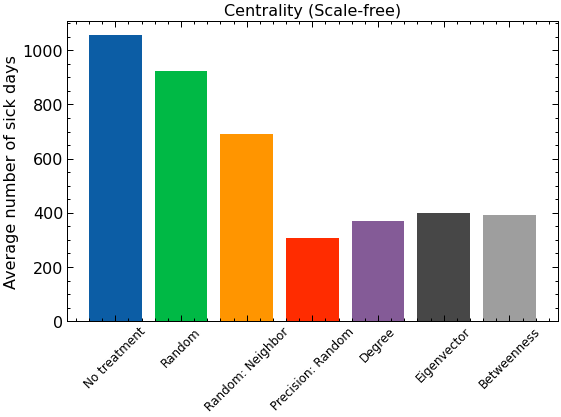

In [88]:
metrics = [null_metrics, rng_metrics, rnn_metrics, prr_metrics, deg_metrics, eig_metrics, btw_metrics]
labels = ["No treatment", "Random", "Random: Neighbor", "Precision: Random", "Degree", "Eigenvector", "Betweenness"]

plt.figure()
plt.title("Centrality (Scale-free)")
plt.ylabel("Average number of sick days")
plt.xticks(rotation=45)
plt.tick_params(axis="x", labelsize=12)
for metric, label in zip(metrics, labels):
    total_sickdays = metric["total_sickdays"] / N
    plt.bar(label, total_sickdays, label=label)
plt.tight_layout()
plt.savefig("out/nb-scalefree-sickdays.jpg")
plt.show()

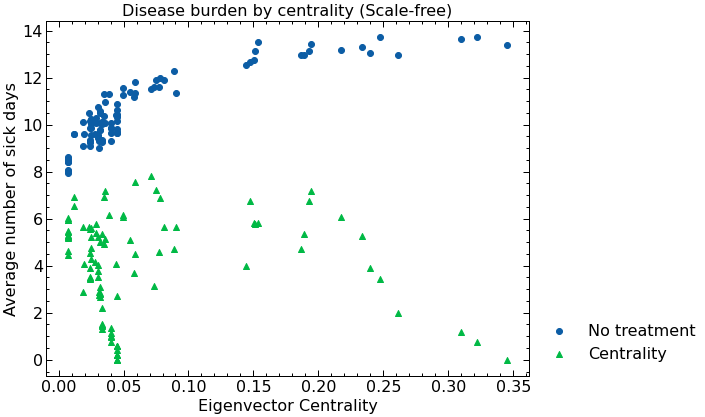

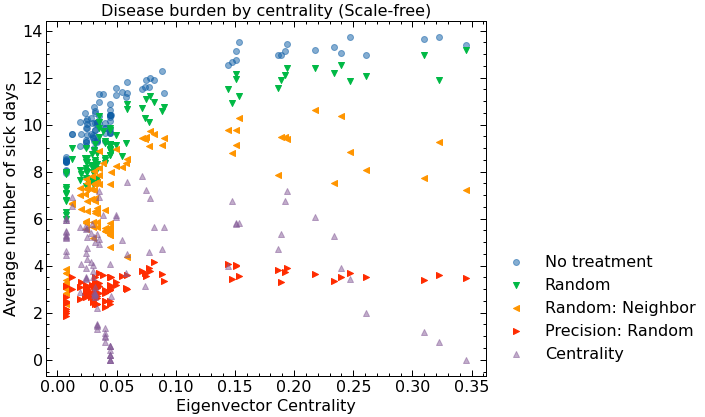

In [137]:
G = ide.GRAPHS["scale"]
# deg_cent = nx.centrality.degree_centrality(G).values()
eig_cent = nx.centrality.eigenvector_centrality(G).values()
# btw_cent = nx.centrality.betweenness_centrality(G).values()

plt.figure(figsize=(10, 6))
plt.title("Disease burden by centrality (Scale-free)")
plt.ylabel("Average number of sick days")
plt.xlabel("Eigenvector Centrality")

plt.scatter(eig_cent, null_metrics["num_sickdays"] / N, label="No treatment")
# plt.scatter(eig_cent, rng_metrics["num_sickdays"] / N, label="Random", marker="v", alpha=0.75)
# plt.scatter(eig_cent, rnn_metrics["num_sickdays"] / N, label="Random: Neighbor", marker="<", alpha=0.75)
# plt.scatter(eig_cent, prr_metrics["num_sickdays"] / N, label="Precision: Random", marker=">", alpha=0.75)
plt.scatter(eig_cent, eig_metrics["num_sickdays"] / N, label="Centrality", marker="^")

plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
plt.tight_layout()
plt.savefig("out/nb-scalefree-centrality-1.jpg")
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Disease burden by centrality (Scale-free)")
plt.ylabel("Average number of sick days")
plt.xlabel("Eigenvector Centrality")

plt.scatter(eig_cent, null_metrics["num_sickdays"] / N, label="No treatment", alpha=0.5)
plt.scatter(eig_cent, rng_metrics["num_sickdays"] / N, label="Random", marker="v")
plt.scatter(eig_cent, rnn_metrics["num_sickdays"] / N, label="Random: Neighbor", marker="<")
plt.scatter(eig_cent, prr_metrics["num_sickdays"] / N, label="Precision: Random", marker=">")
plt.scatter(eig_cent, eig_metrics["num_sickdays"] / N, label="Centrality", marker="^", alpha=0.5)

plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
plt.tight_layout()
plt.savefig("out/nb-scalefree-centrality-2.jpg")
plt.show()

# CENT = [deg_cent, eig_cent, btw_cent]
# cent_metrics = [deg_metrics, eig_metrics, btw_metrics]
# labels = ["Degree", "Eigenvector", "Betweenness"]

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, sharey=True)
# fig.suptitle("Disease burden by centrality (Scale-free)")
# fig.supylabel("Average number of sick days")
# for ax, cent, metric, label in zip(axes, CENT, cent_metrics, labels):
#     ax.set_xlabel(label)
#     ax.scatter(cent, null_metrics["num_sickdays"] / N, label="No treatment")
#     ax.scatter(cent, rng_metrics["num_sickdays"] / N, label="Random", marker="v", alpha=0.5)
#     ax.scatter(cent, rnn_metrics["num_sickdays"] / N, label="Random: Neighbor", marker="v", alpha=0.5)
#     ax.scatter(cent, prr_metrics["num_sickdays"] / N, label="Precision: Random", marker="x")
#     ax.scatter(cent, metric["num_sickdays"] / N, label="Centrality", marker="^")
# axes[3].axis("off")
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="center right")
# fig.tight_layout()
# fig.savefig("out/nb-scalefree-centrality.jpg")